In [8]:
import glob
import pickle
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt

In [9]:
root = '.\\results\\gradient_analysis\\'
results = defaultdict(lambda: {'mean': None, 'std': None})

for fn in glob.glob(root + '**/means.pkl', recursive=True):
    dataset, gnn, dropout, prob, _ = fn.lstrip(root).split('\\')
    prob = float(prob.split('=')[1]) / 100.
    with open(fn, 'rb') as f:
        means = pickle.load(f)
        results[(gnn, dropout, prob)]['mean'] = np.array(means)

for fn in glob.glob(root + '**/std-devs.pkl', recursive=True):
    dataset, gnn, dropout, prob, _ = fn.lstrip(root).split('\\')
    prob = float(prob.split('=')[1]) / 100.
    with open(fn, 'rb') as f:
        stdevs = pickle.load(f)
        results[(gnn, dropout, prob)]['std'] = np.array(stdevs)

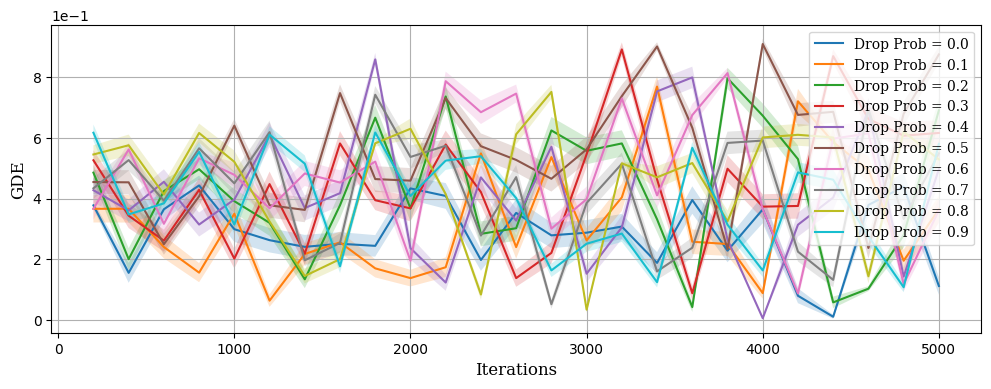

In [10]:
fontdict = {'font':'serif', 'size':12}
plt.figure(figsize=(12,4))

batches = range(200, 5001, 200)
for (gnn, dropout, prob), result in results.items():
    mean = result['mean']; std = result['std']
    mean = 0.5*(1-mean); std = 0.5*std
    plt.plot(batches, mean, label=f'Drop Prob = {prob}')
    plt.fill_between(batches, mean-0.1*std, mean+0.1*std, alpha=0.2)

plt.xlabel('Iterations', fontdict=fontdict)
plt.ylabel('GDE', fontdict=fontdict)
plt.xticks(fontsize=fontdict['size']-2); plt.yticks(fontsize=fontdict['size']-2)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.grid()
plt.legend(prop={'family':fontdict['font'],'size':fontdict['size']-2})
plt.show()

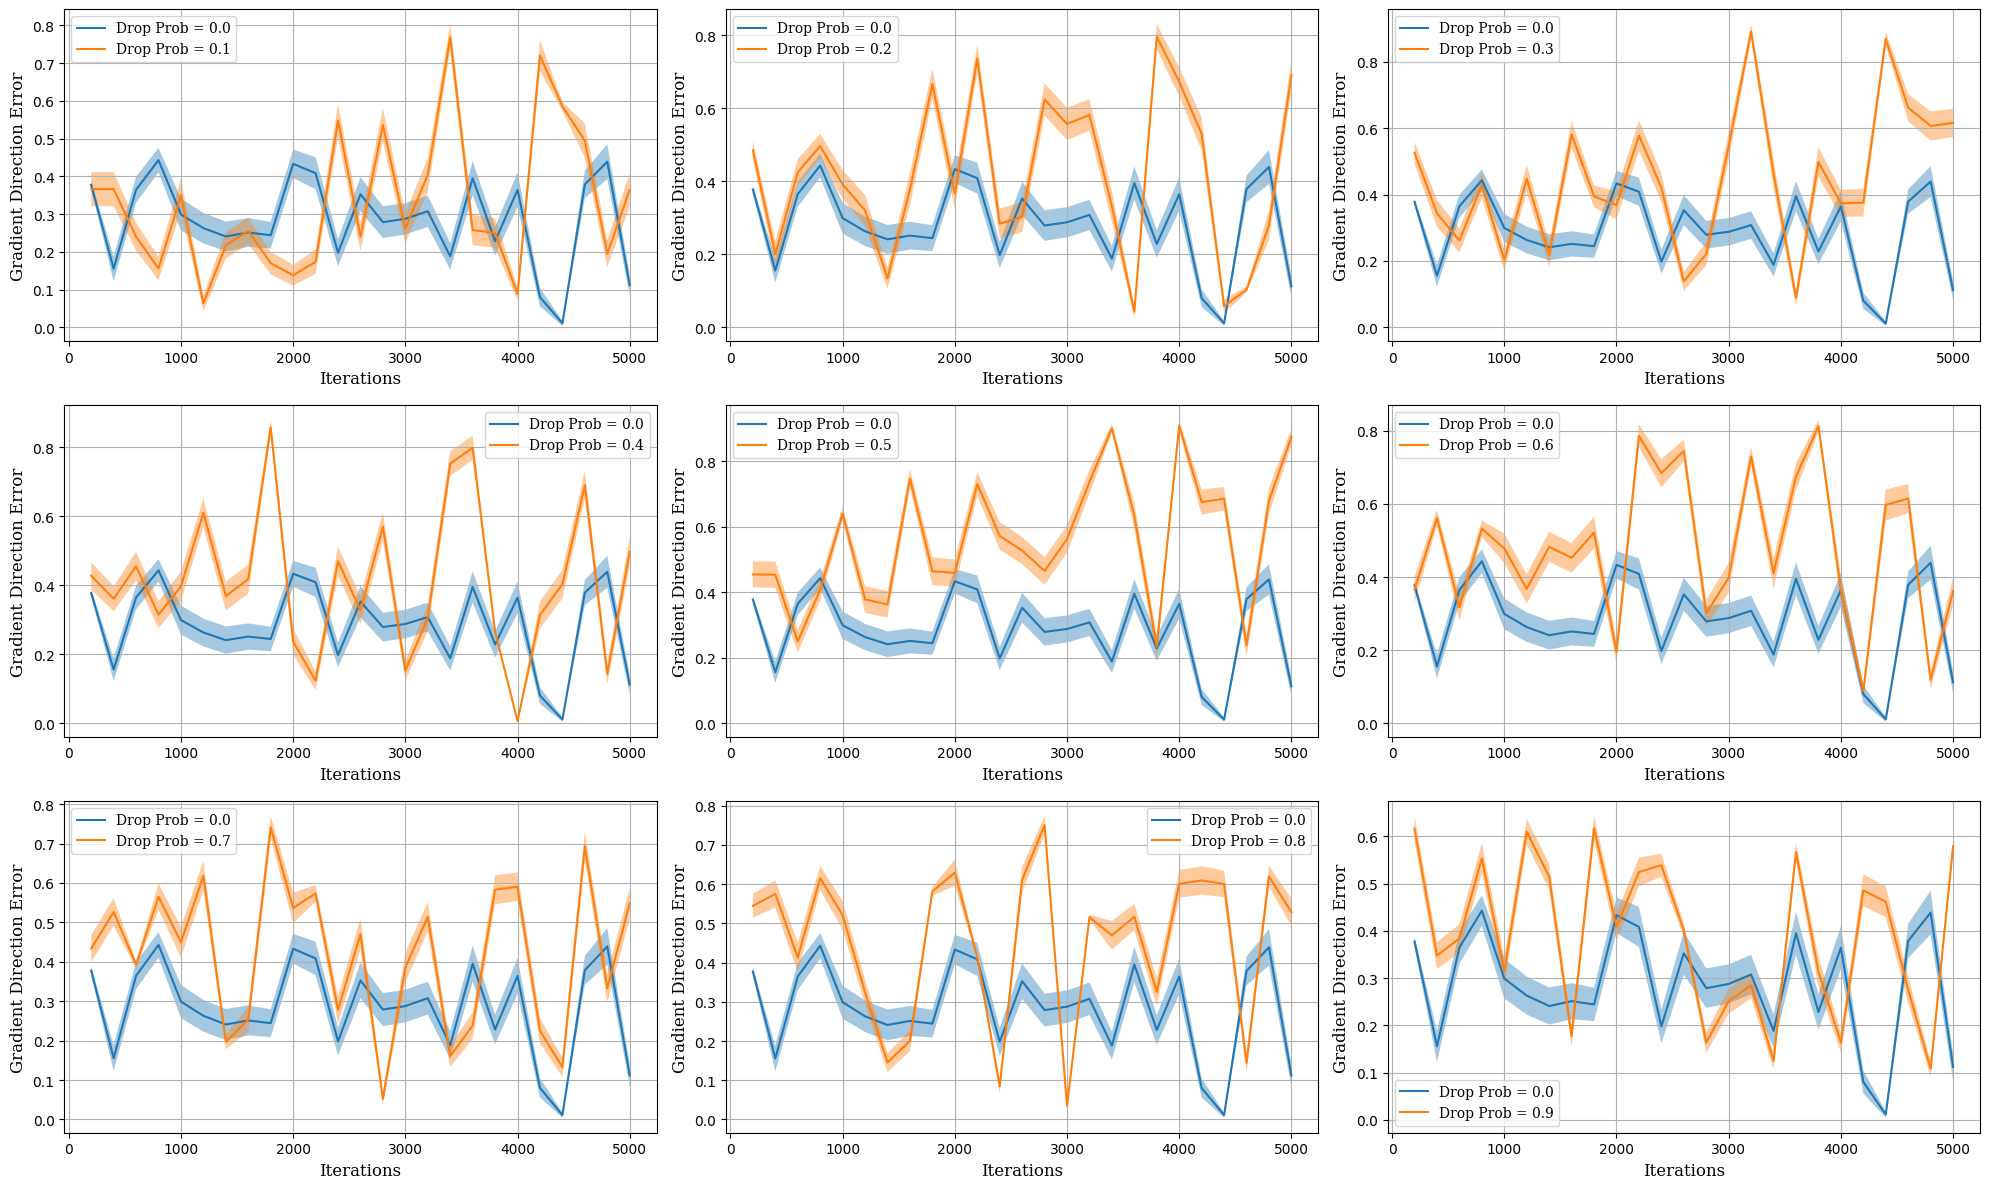

In [11]:
fontdict = {'font':'serif', 'size':12}
fig, axs = plt.subplots(3, 3, figsize=(20,12))
batches = range(200, 5001, 200)

for i, drop_p in enumerate(range(10, 91, 10)):
    
    ax = axs[i//3, i%3]; drop_p = drop_p / 100
    for p in (0.0, drop_p):
        result = results[('GCN', 'Dropout', p)]
        mean = result['mean']; std = result['std']
        mean = 0.5*(1-mean); std = 0.5*std
        ax.plot(batches, mean, label=f'Drop Prob = {p}')
        ax.fill_between(batches, mean-0.1*std, mean+0.1*std, alpha=0.4)

    ax.set_xlabel('Iterations', fontdict=fontdict)
    ax.set_ylabel('Gradient Direction Error', fontdict=fontdict)
    ax.grid()
    ax.legend(prop={'family':fontdict['font'],'size':fontdict['size']-2})

fig.tight_layout()
plt.show()